Index(['EURUSD', 'GBPUSD', 'USDJPY', 'AUDUSD', 'USDCAD', 'NZDUSD', 'USDCHF'], dtype='object')

Johansen Test Results (Trace Statistic):
Rank 0: Trace Stat = 112.34 | 5% CV = 125.62 | Not significant
Rank 1: Trace Stat = 73.13 | 5% CV = 95.75 | Not significant
Rank 2: Trace Stat = 41.47 | 5% CV = 69.82 | Not significant
Rank 3: Trace Stat = 25.60 | 5% CV = 47.85 | Not significant
Rank 4: Trace Stat = 11.90 | 5% CV = 29.80 | Not significant
Rank 5: Trace Stat = 5.67 | 5% CV = 15.49 | Not significant
Rank 6: Trace Stat = 0.01 | 5% CV = 3.84 | Not significant

Most cointegrated pair (Engle-Granger): USDCAD and NZDUSD | p-value: 0.0036


C:\Users\gavra\AppData\Local\Temp\ipykernel_1924\2074184738.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]


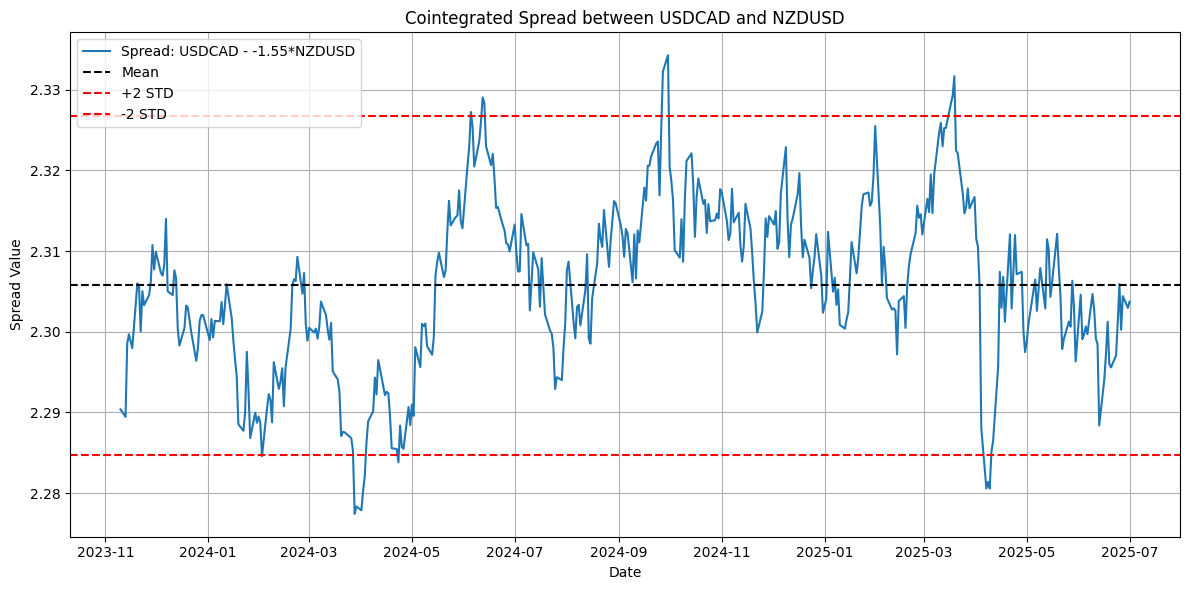

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# establish MT5 connection
if not mt5.initialize(login=93743634, server="MetaQuotes-Demo",password="*4VqApIo"):
    print("initialize() failed, error code =",mt5.last_error())
    quit()

symbols = ['EURUSD', 'GBPUSD', 'USDJPY', 'AUDUSD', 'USDCAD', 'NZDUSD', 'USDCHF']

# define timeframe and number of days
timeframe = mt5.TIMEFRAME_D1  
n_days = 600
utc_to = datetime.now()
utc_from = utc_to - timedelta(days=n_days)

# ownload historical data for each symbol
data = {}

for symbol in symbols:
    # make sure the symbol is available in Market Watch
    mt5.symbol_select(symbol, True)
    
    # get historical rates
    rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_to)
    
    if rates is None or len(rates) == 0:
        print(f"No data for {symbol}.")
        continue

    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    data[symbol] = df['close']

# shutdown MT5 connection
mt5.shutdown()

# combine into one DataFrame
prices = pd.concat(data.values(), axis=1)
prices.columns = data.keys()
prices.dropna(inplace=True)

data = prices
print(data.columns)  # Add this line to inspect columns

# drop any rows with missing values
data.dropna(inplace=True)

# Johansen Cointegration Test
log_prices = data.apply(np.log)

johansen_result = coint_johansen(log_prices, det_order=0, k_ar_diff=1)

# Trace statistics and critical values
print("\nJohansen Test Results (Trace Statistic):")
for i, stat in enumerate(johansen_result.lr1):
    cv = johansen_result.cvt[i, 1]  # 5% critical value
    print(f"Rank {i}: Trace Stat = {stat:.2f} | 5% CV = {cv:.2f} | {'Significant' if stat > cv else 'Not significant'}")

# Engle-Granger Cointegration Test
pairs = [(a, b) for i, a in enumerate(data.columns) for j, b in enumerate(data.columns) if i < j]
results = []
for a, b in pairs:
    score, pvalue, _ = coint(data[a], data[b])
    results.append((a, b, pvalue))

results.sort(key=lambda x: x[2])
best_pair = results[0]
a, b = best_pair[0], best_pair[1]
print(f"\nMost cointegrated pair (Engle-Granger): {a} and {b} | p-value: {best_pair[2]:.4f}")


# estimate hedge ratio via linear regression (OLS)
X = sm.add_constant(data[b])
model = sm.OLS(data[a], X).fit()
hedge_ratio = model.params[1]

# calculate spread
spread = data[a] - hedge_ratio * data[b]

# plot
plt.figure(figsize=(12, 6))
plt.plot(spread.index, spread, label=f'Spread: {a} - {hedge_ratio:.2f}*{b}')
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.axhline(spread.mean() + 2*spread.std(), color='red', linestyle='--', label='+2 STD')
plt.axhline(spread.mean() - 2*spread.std(), color='red', linestyle='--', label='-2 STD')
plt.title(f'Cointegrated Spread between {a} and {b}')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# save data to CSV
data.to_csv('forex_data.csv', index=True)